In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from matplotlib import rcParams
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.datasets import VisionDataset
from torchvision import transforms
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
import math
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import random
import copy
import ray
# from torch.utils.tensorboard import SummaryWriter
import os, json , time 
from tqdm import trange
import sys

  0%|          | 0/3999 [00:00<?, ?it/s]/tmp/ipykernel_36056/2020019748.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(Logistic_Regression_FL_RaM pid=103296) /tmp/ipykernel_36056/2020019748.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(Logistic_Regression_FL_RaM pid=103296) /tmp/ipykernel_36056/2020019748.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(Logistic_Regression_FL_RaM pid=103296) /tmp/ipykernel_36056/2020019748.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

(Logistic_Regression_FL_RaM pid=103296)  For a= 1.0  the Sampling counts = [2010, 1609, 380], a_i: [0.4856964241060265, 0.3954488622155539, 0.1188547136784196] 
(Logistic_Regression_FL_RaM pid=103296) Test RMSE: 0.9272
(Logistic_Regression_FL_RaM pid=103296) For a=1.0, Test Loss: 0.8596, Test RMSE: 0.9272


100%|█████████▉| 3998/3999 [13:53<00:00,  4.80it/s]m 


(Logistic_Regression_FL_RaM pid=103295)  For a= 0.1  the Sampling counts = [1993, 1600, 406], a_i: [0.4818704676169042, 0.3934233558389597, 0.12470617654413603] 
(Logistic_Regression_FL_RaM pid=103295) Test RMSE: 0.7489
(Logistic_Regression_FL_RaM pid=103295) For a=0.1, Test Loss: 0.5609, Test RMSE: 0.7489


100%|██████████| 3999/3999 [13:53<00:00,  4.80it/s]m 


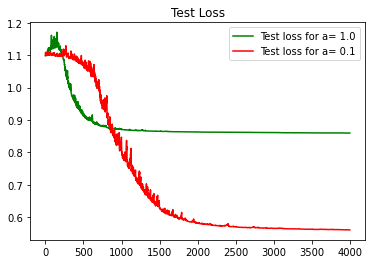

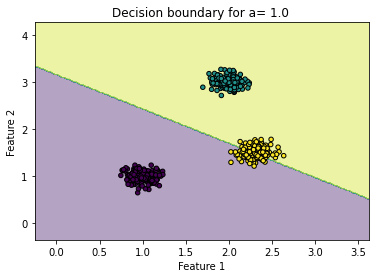

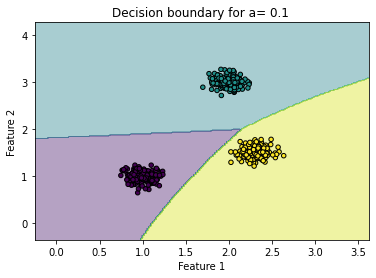

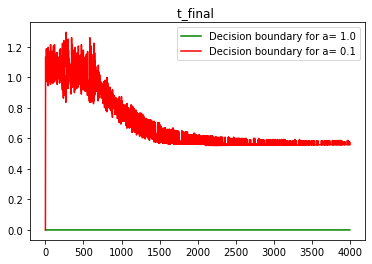

In [20]:
#############################################################################
#############################################################################
################### Motivating example with 3 classes - 3 users #############

# Hyperparameters
# two choices for a. a=1. (risk-neutral), a=0.1 (risk-aware)
cvar_alpha_list = [1.,0.1]
# parameeter gamma
gamma = 0.1
# number of users
K = 3
# number of global rounds
T = 4000
# number of local epochs
H = 10
# users probabilities
user_probs = [  0.5 , 0.4, 0.1 ]
# choose how many users the RAM will allow to send to the server
users_per_round = 1
# learning rates for theta and t, respectively
learning_rate , learning_rate_t = 0.001 , 0.001
# beta parameter is used for visualizing purpose (not necessary for the algorithm)
beta =0.9
boundary_list = []
t_final_list = []
##########################################################################################################################################################
##########################################################################################################################################################

##########################################################################################################################################################
##########################################################################################################################################################
# Generate 2D-synthetic dataset
# number of points for each class
num_points = 1000
X, y = make_blobs(n_samples=[num_points,num_points, num_points ], centers=[(1, 1),(2, 3),(2.3, 1.5)], cluster_std=[0.1,0.1, 0.1], n_features=1, shuffle=False, random_state=11)
# number of classes
num_classes = len(np.unique(y))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Convert training and testing set into tebsors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # Convert to PyTorch tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32) # Convert to PyTorch tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 

# Distribute the data to the users
data_users = [X_train_tensor[y_train==i] for i in [0,1,2]]
labels_users = [y_train_tensor[y_train==i] for i in [0,1,2]]

# Plot the data points
# plt.scatter(data_users[0][:,0], data_users[0][:,1],c=labels_users[0], cmap='BrBG',s=10, edgecolors='green')
# plt.scatter(data_users[1][:,0], data_users[1][:,1],c=labels_users[1], cmap='BrBG',s=20, edgecolors='red')
# plt.scatter(data_users[2][:,0], data_users[2][:,1],c=labels_users[2], cmap='BrBG',s=10, edgecolors='black')
##########################################################################################################################################################
##########################################################################################################################################################

##########################################################################################################################################################
##########################################################################################################################################################
# Define the RAM model
def RAM(user_weights,K,user_probs,users_per_round,t_list):
    user_index = random.choices(range(K), weights=user_probs, k=users_per_round)[0]
    return user_weights[user_index],user_index , t_list[user_index]
##########################################################################################################################################################
##########################################################################################################################################################

##########################################################################################################################################################
##########################################################################################################################################################
# Define the model neural network
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(2, 64)
        self.layer2 = nn.Linear(64, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.layer1.weight.data = torch.zeros([64,2])
        self.layer2.weight.data = torch.zeros([3,64])

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.softmax(x)
        return x
##########################################################################################################################################################
##########################################################################################################################################################


ray.init(log_to_driver=False)
# for cvar_alpha in cvar_alpha_list:
@ray.remote(num_gpus=0.2,max_calls=0)
# the  main function used in this example for both values of the parameter a.
def Logistic_Regression_FL_RaM(cvar_alpha):

    # Initialize the model and define the loss 
    global_model = MyModel()
    
    # Define the loss 
    loss_fn = nn.CrossEntropyLoss()
    
    # Initialize the parameters theta and t
    # Initialize the parameter theta 
    global_theta = global_model.state_dict()
    user_weights = [ global_theta.copy() for _ in range(K) ] 
    t_list = [ torch.tensor(  0.  , requires_grad=True) for _ in range(K)  ]
    
    ##############################################
    # The next two commants are important only for plotting (Not essential for the algorithm) 
    sampling_counts, a_0  = [0] * K , 1/K
    a_i = [0] * K
    ##############################################

    t_list_track = []
    test_loss_per_a = []
    # start the training 
    for epoch in trange(1,T):
        # pass the model in training mode
        global_model.train()

        # RAM send one user and its parameter (theta,t) to the Server
        global_theta , user_index , global_t = RAM(user_weights,K,user_probs,users_per_round,t_list)
        
        #################################################################
        #################################################################
        # Update the appropriate lists in order to visualize the parameters 
        global_t = torch.tensor(global_t , requires_grad=True)
        t_list_track.append(global_t.item())

        ###########################################################################
        #################### Counter of the user Availability #####################
        sampling_counts[user_index] += 1
        n_i = sampling_counts[user_index]
        n = epoch
        fraction_n_i_n = n_i / n if n != 0 else 1.0

        for i in range(K):
            a_i[i] = (1 - beta) * a_0 + beta * sampling_counts[i]/n

        if round(sum(a_i)) != 1:
            print("fraction_n_i_n",fraction_n_i_n)
            print("a_i:",a_i)
            sys.exit("List a_i has not sum equal to 1")
        ###########################################################################
        ###########################################################################
        global_model.load_state_dict(global_theta)

        for user in range(K):
            f_local = copy.deepcopy(global_model)
            f_local.requires_grad_(True)

            x_train_tensor = torch.tensor(data_users[user], dtype=torch.float32)
            y_train_tensor = torch.tensor(labels_users[user], dtype=torch.long)
            
            # Define the data loader
            train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
            batch_size =    100
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Set optimizers of theta and t
            optimizer = optim.SGD(f_local.parameters(), lr=learning_rate)
            global_t = torch.tensor(global_t,requires_grad=True)
            optimizer_t = torch.optim.SGD([global_t], lr=learning_rate_t  )
            
            # For each global epoch
            for _ in range(H):
                # Loop over the data loader
                for i, (batch_x, batch_y) in enumerate(train_loader):
                    # Forward pass
                    outputs = f_local(batch_x)

                    # empirical local loss
                    f_i = loss_fn(outputs, batch_y)
                    # risk-aware local loss
                    cvar_loss = (1-gamma) * global_t + ((1-gamma) * torch.relu(f_i - global_t))/cvar_alpha + gamma * f_i
                    
                    # optimize steps
                    optimizer.zero_grad()
                    optimizer_t.zero_grad()
                    cvar_loss.backward(retain_graph = True)
                    
                    optimizer.step()
                    optimizer_t.step()
            # update the lists with users new theta's and t's
            user_weights[user] = f_local.state_dict()
            t_list[ user ] = global_t.item()

        with torch.no_grad():
            global_model.load_state_dict(global_theta)
            ##############################################
            # pass the model in testing phase
            global_model.eval() 

            y_pred = global_model(x_test_tensor)
            test_loss = loss_fn(y_pred, y_test_tensor)
            test_loss_per_a.append(test_loss)
    print(f" For a= {cvar_alpha}  the Sampling counts = {sampling_counts}, a_i: {a_i} ")    
        
    ############################################################################################
    ############################################################################################
    # Evaluate the model
    # Plot the data and the decision boundary
    t_final_list.append(t_list_track)
    with torch.no_grad():
        global_model.load_state_dict(global_theta)
        ##############################################
        # pass the model in testing phase
        global_model.eval() 

        y_pred = global_model(x_test_tensor)
        test_loss = loss_fn(y_pred, y_test_tensor)
        # test_loss_per_a = test_loss
        # calculate the RMSE for the test data
        rmse = torch.sqrt(test_loss)
        print(f'Test RMSE: {rmse.item():.4f}')
        print(f'For a={cvar_alpha}, Test Loss: {test_loss:.4f}, Test RMSE: {rmse.item():.4f}')

        
        # Make predictions for each point in the grid
        # Create a meshgrid of points in the feature space
        x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
        y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
        X_grid = np.c_[xx.ravel(), yy.ravel()]

        # Predict the class labels for each point in the meshgrid
        Z = np.argmax(global_model(torch.tensor(X_grid, dtype=torch.float32)).detach().numpy(), axis=1)
        Z = Z.reshape(xx.shape)
    
    return xx, yy, Z , t_list_track , test_loss_per_a
ray.shutdown()

results = ray.get( [ Logistic_Regression_FL_RaM.remote(cvar_alpha) for cvar_alpha in cvar_alpha_list ] )

xx = [result[0] for result in results]
yy = [result[1] for result in results]
Z = [result[2] for result in results]
t_list_track = [result[3] for result in results]
test_loss_track = [result[4] for result in results]

############################################################################################
############################################################################################
### Plot the testing losses
# Plot the testing loss for a = 1 and a = 0.1
plt.figure()
plt.plot(test_loss_track[0],color='green', label=f'Test loss for a= {cvar_alpha_list[0]}') # cvar_alpha_list[0] = a = 1
plt.plot(test_loss_track[1],color='red', label=f'Test loss for a= {cvar_alpha_list[1]}')  # # cvar_alpha_list[1] = a = 0.1
# plt.savefig(f'Global t for a = [{cvar_alpha_list[0]},{cvar_alpha_list[1]}].pdf')
plt.title(f'Test Loss')
plt.legend()
plt.show()




### Plot the decision boundaries
plt.figure()
plt.contourf(xx[0], yy[0], Z[0], alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title(f'Decision boundary for a= {cvar_alpha_list[0]} ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.savefig(f'Decision boundary for a = [{cvar_alpha_list[0]}].pdf')
plt.show()

plt.figure()
plt.contourf(xx[1], yy[1], Z[1], alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title(f'Decision boundary for a= {cvar_alpha_list[1]} ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.savefig(f'Decision boundary for a = [{cvar_alpha_list[1]}].pdf')

plt.show()


plt.figure()
plt.plot(t_list_track[0],color='green', label=f'Decision boundary for a= {cvar_alpha_list[0]}')
plt.plot(t_list_track[1],color='red', label=f'Decision boundary for a= {cvar_alpha_list[1]}')
# plt.savefig(f'Global t for a = [{cvar_alpha_list[0]},{cvar_alpha_list[1]}].pdf')
plt.title(f't_final ')
plt.legend()
plt.show()


In [19]:
ray.shutdown()

[tensor(1.1122), tensor(1.1014)]

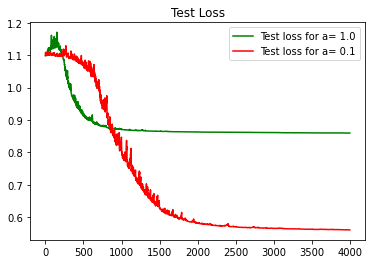

In [23]:
plt.figure()
plt.plot(test_loss_track[0],color='green', label=f'Test loss for a= {cvar_alpha_list[0]}') # cvar_alpha_list[0] = a = 1
plt.plot(test_loss_track[1],color='red', label=f'Test loss for a= {cvar_alpha_list[1]}')  # # cvar_alpha_list[1] = a = 0.1
plt.title(f'Test Loss')
plt.legend()
plt.savefig(f'Test Loss a = [{cvar_alpha_list[0]},{cvar_alpha_list[1]}].pdf')
plt.show()

### Plot the testing losses
# Plot the testing loss for a = 1 and a = 0.1
plt.figure()
plt.plot(test_loss_track[0],color='green', label=f'Test loss for a= {cvar_alpha_list[0]}') # cvar_alpha_list[0] = a = 1
plt.plot(test_loss_track[1],color='red', label=f'Test loss for a= {cvar_alpha_list[1]}')  # # cvar_alpha_list[1] = a = 0.1
# plt.savefig(f'Global t for a = [{cvar_alpha_list[0]},{cvar_alpha_list[1]}].pdf')
plt.title(f'Test Loss')
plt.legend()
plt.show()




### Plot the decision boundaries
plt.figure()
plt.contourf(xx[0], yy[0], Z[0], alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title(f'Decision boundary for a= {cvar_alpha_list[0]} ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.savefig(f'Decision boundary for a = [{cvar_alpha_list[0]}].pdf')
plt.show()

plt.figure()
plt.contourf(xx[1], yy[1], Z[1], alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title(f'Decision boundary for a= {cvar_alpha_list[1]} ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.savefig(f'Decision boundary for a = [{cvar_alpha_list[1]}].pdf')

plt.show()


plt.figure()
plt.plot(t_list_track[0],color='green', label=f'Decision boundary for a= {cvar_alpha_list[0]}')
plt.plot(t_list_track[1],color='red', label=f'Decision boundary for a= {cvar_alpha_list[1]}')
plt.title(f't_final ')
plt.legend()
plt.savefig(f'Global t for a = [{cvar_alpha_list[0]},{cvar_alpha_list[1]}].pdf')
plt.show()
